# Recurrent Neural Networks
---
# Predicting Stock Prices through an LSTM model

In [1]:
import tensorflow as tf

''' Linear Algebra '''
import pandas as pd
import numpy as np
pd.set_option("max_columns",None)

'''Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [2]:
''' Hnadling timestamps'''
import datetime
from datetime import datetime

In [3]:
# tech stocks
coin = ['BTC', 'ETH']

In [4]:
# today
end = datetime.now()

In [5]:
start = datetime(2012, 1, 1)
start

datetime.datetime(2012, 1, 1, 0, 0)

In [6]:
url = 'https://raw.githubusercontent.com/timjab92/cryptotradingindicator/master/data/BTCUSD_4hours.csv'

data = pd.read_csv(url)
# Dataset is now stored in a Pandas Dataframe

In [7]:
coin_selection = "BTC"
# coin_data = {"BTC":"BTCUSD_4hours.csv"}

# data = pd.read_csv(data_path + coin_data[coin_selection])

data = data.drop(columns="Unnamed: 0").set_index("date")
data = data[10000:]
data

,open,high,low,close,volume,log_open,log_high,log_low,log_close
date,,,,,,,,,
2016-09-11 16:00:00,622.530173,622.773815,622.393815,622.601965,0.645503,6.433792,6.434183,6.433573,6.433907
2016-09-11 20:00:00,608.858585,609.295377,608.338821,608.752830,21.064810,6.411376,6.412097,6.410514,6.411200
2016-09-12 00:00:00,604.478168,604.792618,604.236335,604.450576,3.045742,6.404364,6.404884,6.403964,6.404318
2016-09-12 04:00:00,605.892222,606.177516,605.676405,605.881569,2.487445,6.406701,6.407171,6.406345,6.406684
2016-09-12 08:00:00,605.702602,606.161735,605.157959,605.682296,5.324050,6.406387,6.407145,6.405488,6.406353
...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660


In [8]:
## add other features

def add_ema(data, tspan=[12,26,20,50,34,55]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data.log_close.ewm(span=t).mean()
    return data

add_ema(data)

def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi



rsi = computeRSI(data)

def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  

stoch_rsi(rsi)

def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data['log_close'], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data

add_stoch_rsi(data)

def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down

prices = data["log_close"]

get_bollinger_bands(prices, rate=20)

def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    return data

add_bollinger(data,prices)

def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data

add_vol_roc(data)
data.head(3)

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,ema26,ema20,ema50,ema34,ema55,rsi,K,D,sma,bollinger_up,bollinger_down,vol_roc
date,,,,,,,,,,,,,,,,,,,,,,
2016-09-11 16:00:00,622.530173,622.773815,622.393815,622.601965,0.645503,6.433792,6.434183,6.433573,6.433907,6.433907,6.433907,6.433907,6.433907,6.433907,6.433907,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-11 20:00:00,608.858585,609.295377,608.338821,608.752830,21.064810,6.411376,6.412097,6.410514,6.411200,6.421607,6.422117,6.421986,6.422326,6.422220,6.422347,NaN,NaN,NaN,NaN,NaN,NaN,31.633193
2016-09-12 00:00:00,604.478168,604.792618,604.236335,604.450576,3.045742,6.404364,6.404884,6.403964,6.404318,6.414859,6.415722,6.415498,6.416082,6.415898,6.416118,NaN,NaN,NaN,NaN,NaN,NaN,-0.855411


### Daily return

$ return = \frac{new - old}{old} $

In [9]:
data['4h Return'] = data['close'].pct_change()
data['4h Gradient'] = data['close'].diff()
data['boll_width'] = data['bollinger_up'] - data['bollinger_down']
data['stoch_rsi'] = (data['K'] + data['D']) / 2

In [10]:
data = data.dropna()

## Time-Series Visualisation

### Historical Stock Prices

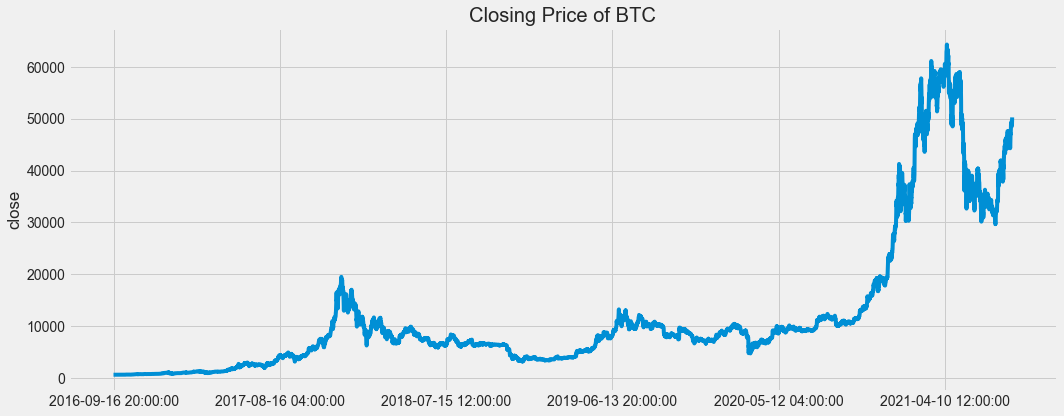

In [11]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

data['close'].plot()
plt.ylabel('close')
plt.xlabel(None)
plt.title(f"Closing Price of {coin_selection}")
    
plt.tight_layout()

### Volumes traded

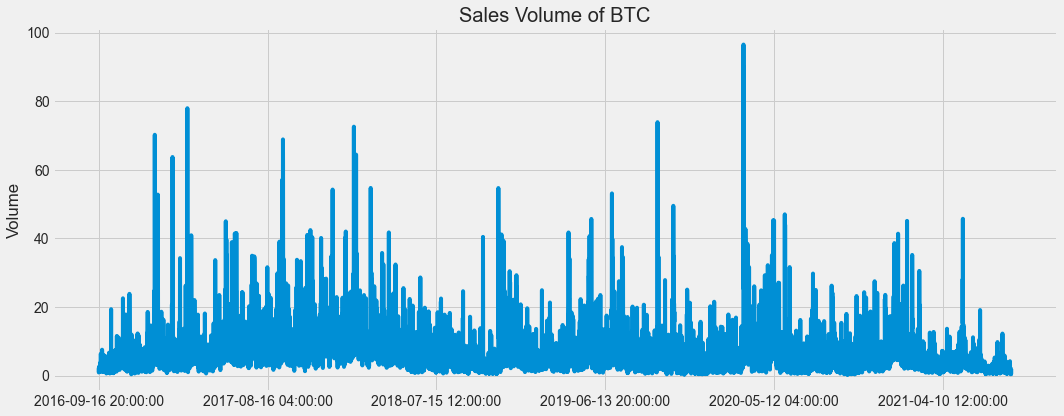

In [12]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

data['volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Sales Volume of BTC")
    
plt.tight_layout()

In [13]:
data.head()

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,ema26,ema20,ema50,ema34,ema55,rsi,K,D,sma,bollinger_up,bollinger_down,vol_roc,4h Return,4h Gradient,boll_width,stoch_rsi
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-16 20:00:00,606.420076,606.511450,606.326031,606.412748,2.307185,6.407572,6.407723,6.407417,6.407560,6.408324,6.408770,6.408638,6.409010,6.408882,6.409036,40.074263,66.832576,68.633211,6.409163,6.412655,6.405670,-0.592995,0.001020,0.618162,0.006985,67.732894
2016-09-17 00:00:00,606.393333,606.546449,606.200652,606.373841,0.914466,6.407528,6.407780,6.407210,6.407496,6.408196,6.408667,6.408525,6.408929,6.408790,6.408957,39.930892,54.323486,64.618565,6.409170,6.412646,6.405694,-0.603644,-0.000064,-0.038908,0.006953,59.471026
2016-09-17 04:00:00,605.275088,605.384737,605.165702,605.290175,0.945083,6.405683,6.405864,6.405502,6.405707,6.407812,6.408431,6.408248,6.408759,6.408586,6.408794,36.082672,52.566827,57.907630,6.408919,6.412637,6.405200,0.033480,-0.001787,-1.083665,0.007436,55.237228
2016-09-17 08:00:00,605.660526,605.763263,605.491368,605.612421,1.887662,6.406319,6.406488,6.406039,6.406239,6.407569,6.408257,6.408050,6.408628,6.408432,6.408667,37.996168,47.010486,51.300266,6.408753,6.412644,6.404862,0.997351,0.000532,0.322246,0.007781,49.155376
2016-09-17 12:00:00,605.679435,605.831129,605.474355,605.635484,1.246336,6.406350,6.406601,6.406012,6.406278,6.407370,6.408100,6.407877,6.408507,6.408293,6.408550,38.140984,42.224688,47.267334,6.408580,6.412591,6.404568,-0.339746,0.000038,0.023063,0.008023,44.746011


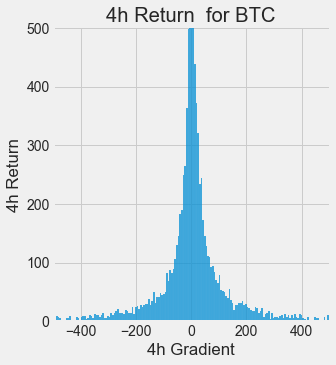

In [14]:
sns.displot(data = data, x= '4h Gradient')
plt.ylabel('4h Return')
plt.xlim([-500,500])
plt.ylim([0,500])
plt.title(f"4h Return  for {coin_selection}");

In [15]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'log_open', 'log_high',
       'log_low', 'log_close', 'ema12', 'ema26', 'ema20', 'ema50', 'ema34',
       'ema55', 'rsi', 'K', 'D', 'sma', 'bollinger_up', 'bollinger_down',
       'vol_roc', '4h Return', '4h Gradient', 'boll_width', 'stoch_rsi'],
      dtype='object')

In [51]:
selected_features = ['close','rsi','ema20','4h Return']
#selected_features=['close','rsi','ema34','bollinger_up','4h Return']
#selected_features=['close','rsi','ema20','ema50','bollinger_up','4h Return']
selected_data = data[selected_features]
selected_data.sample(10)

,close,rsi,ema20,4h Return
date,,,,
2020-04-30 20:00:00,8762.166583,71.340116,9.027715,0.001790
2017-12-25 16:00:00,13907.532042,42.603922,9.564566,-0.016897
2020-05-17 08:00:00,9512.460133,57.488540,9.149266,-0.000922
2017-10-04 04:00:00,4305.708190,54.219230,8.367211,0.001872
2018-09-18 04:00:00,6250.870419,27.561742,8.765067,0.000109
2017-12-24 04:00:00,14040.910708,37.376570,9.613085,-0.021357
2019-04-30 16:00:00,5250.380586,58.514419,8.553350,0.009768
2019-03-29 00:00:00,4014.749912,63.936064,8.290774,0.001116
2017-08-31 04:00:00,4614.007763,71.437253,8.408912,0.005771


##  BTC Stock Price

### Temporal Train-Test Split

In [52]:
train_percentage = 95

In [53]:
train_len = int(len(selected_data) * train_percentage/100)
train_len

10268

In [54]:
data_train = selected_data[:train_len]
data_test = selected_data[train_len:]


In [55]:
print(data_train.head(1))
print(data_train.tail(1))

                          close        rsi     ema20  4h Return
date                                                           
2016-09-16 20:00:00  606.412748  40.074263  6.408638    0.00102
                            close       rsi      ema20  4h Return
date                                                             
2021-05-25 00:00:00  38797.501625  54.55266  10.525413  -0.001147


## LSTM

In [56]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler(feature_range = (0,1))

minmax_scaler.fit(data_train)

data_train_scaled = minmax_scaler.transform(data_train)
data_test_scaled = minmax_scaler.transform(data_test)

In [57]:
minmax_scaler.data_max_

array([6.43385212e+04, 9.62292080e+01, 1.10425427e+01, 1.35906830e-01])

In [58]:
minmax_scaler.data_min_

array([ 5.94187857e+02,  4.35903634e+00,  6.39310696e+00, -1.84592994e-01])

In [59]:
min1 = minmax_scaler.data_min_[0]
min1

594.1878571428572

In [60]:
range1 = minmax_scaler.data_range_[0]
range1

63744.333309523805

### Creating subsequences...

In [61]:
window_size = 18 # test with small window size
horizon = 1 #number of predictions into the future :) 
data_train_subsequences = []
fake_y_train = []
for k in range(len(data_train_scaled)-(window_size-1)-horizon):
    data_train_subsequences.append(data_train_scaled[k:k+window_size])
    fake_y_train.append(data_train_scaled[k+window_size])

In [62]:
X_train = np.array(data_train_subsequences)
y_train = np.array(fake_y_train)[:,0].reshape(-1,1)

In [63]:
X_train.shape

(10250, 18, 4)

In [64]:
y_train.shape

(10250, 1)

In [65]:
#with the same window_size & horizon as the train data
window_size = 18
horizon = 1
data_test_subsequences = []
fake_y_test = []
for k in range(len(data_test_scaled)-(window_size-1)-horizon):
    data_test_subsequences.append(data_test_scaled[k:k+window_size])
    fake_y_test.append(data_test_scaled[k+window_size])

In [66]:
X_test = np.array(data_test_subsequences)
y_test = np.array(fake_y_test)[:,0].reshape(-1,1)

### Baseline

In [67]:
# baseline predictions

X_test_last_seen_value = [_[-1][0] for _ in X_test]

In [68]:
X_test_last_seen_value_uns = np.array(X_test_last_seen_value) * range1 + min1

In [69]:
X_test_last_seen_value_uns = X_test_last_seen_value_uns.reshape(-1,1)

In [70]:
y_test_unscaled = y_test * range1 + min1

In [71]:
np.mean(np.abs(y_test_unscaled - X_test_last_seen_value_uns))

368.74288851468793

### Baseline mape

In [72]:
baseline_mape = np.mean(np.abs((y_test_unscaled - X_test_last_seen_value_uns) / y_test_unscaled)) *100

In [73]:
baseline_mape 

0.994878389011856

### LSTM

#### RNN Architecture

In [74]:
# def create_model():
    
#     # Define architecture without input shape yet, as we don't know the shape post preprocessing
#     model = Sequential()

#     model.add(layers.LSTM(units=128,
#                      return_sequences = True,
#                      activation = "tanh"
#                     #activation = "relu"
#                      #input_shape = X_train[0].shape)
#                      ))

#     model.add(layers.LSTM(units=64,
#                       return_sequences = False,
#                       activation = "relu"  
#                     #activation = "relu"
#                      ))

#     model.add(layers.Dense(32,
#                         activation = "tanh" 
#                        #activation="relu"
#                       ))
#     model.add(layers.Dense(8,
#                        activation = "relu"
#                        #activation="relu"
#                       ))
#     model.add(layers.Dense(1,
#                       activation = "relu" 
#                       #activation="relu"
#                       ))
#     # Compile model
#     model.compile(loss='mse', 
#                   optimizer='adam', 
#                   metrics='mae')
#     return model
    



In [75]:
# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score

In [76]:
# '''
# Then, let's apply a "mask" to disguise this model as a Scikit Learn estimator
# '''
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# model_cv = KerasRegressor(build_fn=create_model, 
#                         epochs=10, 
#                         batch_size=32, 
#                         verbose=0)





In [77]:
# %%time
# '''
# Now, your deep learning model is seen as SKLearn estimator
# You can **cross_validate** it and even **cross_val_score** it.
# '''
# from sklearn.model_selection import cross_validate


# cv_results = cross_validate(model_cv, X_train, y_train, cv=10, n_jobs=-1, scoring="neg_mean_absolute_error")

In [78]:
# -cv_results["test_score"]

In [79]:
# np.mean(-cv_results["test_score"])

In [80]:
# plt.plot(-cv_results["test_score"])

In [81]:
# np.std(-cv_results["test_score"])

In [82]:
#from tensorflow.keras import metrics

#my_mae = metrics.MeanAbsoluteError(
    #name='mean_absolute_error', dtype=None)


In [83]:
from tensorflow.keras import Sequential, layers

# Build the LSTM model
model = Sequential()

model.add(layers.LSTM(units=128,
                     return_sequences = True,
                     activation = "tanh"
                    #activation = "relu"
                     #input_shape = X_train[0].shape)
                     ))

model.add(layers.LSTM(units=64,
                      return_sequences = False,
                      activation = "relu"  
                    #activation = "relu"
                     ))

# model.add(layers.Dense(25,
#                          activation="relu"))
model.add(layers.Dense(32,
                        activation = "tanh" 
                       #activation="relu"
                      ))
#model.add(layers.Dense(16,activation="relu"))
model.add(layers.Dense(8,
                       activation = "relu"
                       #activation="relu"
                      ))
model.add(layers.Dense(1,
                      activation = "relu" 
                      #activation="relu"
                      ))

#model.summary()



In [84]:
model.compile(loss="mse",
             optimizer = "adam",#rmsprop
             metrics = "mae"#[my_mae]
             )

#### Training

In [104]:
from tensorflow.keras.callbacks import EarlyStopping 

es = EarlyStopping(patience = 5, restore_best_weights=True, monitor = "mae")
#monitor = "val_mean_absolute_error"

history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    batch_size=16,
                    epochs=30,
                    verbose = 1,
                    callbacks = [es])

Epoch 1/30
513/513 [==============================] - 6s 11ms/step - loss: 9.2651e-06 - mae: 0.0022 - val_loss: 0.0129 - val_mae: 0.0685
Epoch 2/30
513/513 [==============================] - 6s 11ms/step - loss: 8.5071e-06 - mae: 0.0021 - val_loss: 0.0032 - val_mae: 0.0348
Epoch 3/30
513/513 [==============================] - 6s 11ms/step - loss: 8.0002e-06 - mae: 0.0020 - val_loss: 0.0031 - val_mae: 0.0328
Epoch 4/30
513/513 [==============================] - 6s 11ms/step - loss: 8.0059e-06 - mae: 0.0020 - val_loss: 0.0023 - val_mae: 0.0290
Epoch 5/30
513/513 [==============================] - 6s 12ms/step - loss: 6.4533e-06 - mae: 0.0018 - val_loss: 0.0033 - val_mae: 0.0345
Epoch 6/30
513/513 [==============================] - 6s 11ms/step - loss: 6.9577e-06 - mae: 0.0018 - val_loss: 0.0033 - val_mae: 0.0358
Epoch 7/30
513/513 [==============================] - 6s 12ms/step - loss: 7.6121e-06 - mae: 0.0019 - val_loss: 0.0019 - val_mae: 0.0273
Epoch 8/30
513/513 [=====================

In [ ]:
#def plot_loss_mae(history):
    
    #fig, ax =plt.subplots(1,2,figsize=(20,5))
    
    # --- LOSS
    
    #ax[0].plot(history.history['loss'])
    #ax[0].plot(history.history['val_loss'])
    #ax[0].set_title('Model loss')
    #ax[0].set_xlabel('Epoch')
    #ax[0].set_ylabel('Loss')
    #ax[0].legend(['Train', 'Val'], loc='upper right')
    #ax[0].grid(axis="x",linewidth=0.5)
    #ax[0].grid(axis="y",linewidth=0.5)
    
#     # --- MAE

    #ax[1].plot(history.history['mean_absolute_error'])
    #ax[1].plot(history.history['val_mean_absolute_error'])
    #ax[1].set_title('Model MAE', fontsize = 18)
    #ax[1].set_xlabel('Epoch', fontsize = 14)
    #ax[1].set_ylabel('Recall', fontsize = 14)
    #ax[1].legend(['Train', 'Val'], loc='lower right') 
    #ax[1].grid(axis="x",linewidth=0.5)
    #ax[1].grid(axis="y",linewidth=0.5)   
    
    #plt.show()
    

In [ ]:
#plot_loss_mae(history)

#### Evaluating

In [ ]:
# res = model.evaluate(X_test, y_test, verbose = 1)
# res


#### Predictions

In [96]:
predictions = model.predict(X_test)


In [97]:
len(predictions), len(y_test)

(523, 523)

In [98]:
predictions[0:3]

array([[0.65514493],
       [0.6391287 ],
       [0.6205436 ]], dtype=float32)

In [99]:
y_test_unscaled = y_test * range1 + min1

In [100]:
predictions_unscaled = predictions * range1 + min1

In [101]:
print(pd.DataFrame(y_test_unscaled).tail(5))
print(pd.DataFrame(predictions_unscaled).tail(5))

                0
518  48769.737750
519  48591.580833
520  48810.168750
521  49783.003708
522  50277.475152
                0
518  57550.117188
519  56972.183594
520  56689.640625
521  56914.441406
522  58018.121094


The operation computed during a `MinMaxScaler` Operation is:

$$x_{scaled} = \frac{x - x_{min}}{x_{max}- x_{min}}$$

To descale it:

$$x = x_{scaled} * (x_{max}- x_{min}) + x_{min}$$

Or use the `inverse_transform` directly provided...

In [102]:
np.mean(np.abs(y_test_unscaled - predictions_unscaled))

3715.2238522835924

In [103]:
np.mean(np.abs((y_test_unscaled - predictions_unscaled) / y_test_unscaled)) *100

9.519540244921581

In [94]:
y_test_unscaled.shape

(523, 1)

In [95]:
predictions_unscaled.shape

(523, 1)

In [ ]:
# loss = np.mean(tf.keras.losses.mean_absolute_percentage_error(y_test_unscaled, predictions_unscaled))


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
fig = plt.figure(figsize=(15, 8))

plt.plot(predictions_unscaled, label = "y_pred")
plt.plot(y_test_unscaled, label = "y_test")
plt.legend()
plt.show()

In [ ]:
stop stop 

### Test Model on Coingecko

In [ ]:
import requests

In [ ]:
def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api

In [ ]:
coingecko = get_coingecko()


In [ ]:
coingecko.head()

In [ ]:
add_ema(coingecko)

rsi = computeRSI(coingecko)

stoch_rsi(rsi)

add_stoch_rsi(coingecko)

prices = coingecko["log_close"]

get_bollinger_bands(prices, rate=20)

add_bollinger(coingecko,prices)

add_vol_roc(coingecko)


In [ ]:
coingecko['4h Return'] = coingecko['close'].pct_change()
coingecko['4h Gradient'] = coingecko['close'].diff()

In [ ]:
selected_features = ['close','rsi','bollinger_up','4h Return']
coingecko = coingecko[selected_features]
coingecko.tail(18)

### Test based on 1 window_size and 1 prediction (4 hours in de future) with Coingecko Data

In [ ]:
X_gecko = coingecko.dropna()[-18:]

In [ ]:
X_gecko.shape

In [ ]:
x_gecko_scaled = minmax_scaler.transform(X_gecko)

In [ ]:
x_gecko_scaled_reshaped = x_gecko_scaled.reshape(1,18,4) #18 is the window size, 9 is number of features. 

In [ ]:
predictions_api = model.predict(x_gecko_scaled_reshaped)

In [ ]:
predictions_api

In [ ]:
predictions_api_unscaled = predictions_api * range1 + min1 

In [ ]:
predictions_api_unscaled


### Creating X_test_gecko and y_test_gecko

In [ ]:
X_test_gecko = coingecko.dropna()[-144:]

In [ ]:
print(X_test_gecko.head(1))
print(X_test_gecko.tail(1))

In [ ]:
X_test_gecko_scaled = minmax_scaler.transform(X_test_gecko)

In [ ]:
X_test_gecko.shape

In [ ]:
#with the same window_size & horizon as the train data
window_size = 18
horizon = 1
X_test_gecko_sub = []
fake_y_test_gecko_sub = []
for k in range(len(X_test_gecko_scaled)-(window_size-1)-horizon):
    X_test_gecko_sub.append(X_test_gecko_scaled[k:k+window_size])
    fake_y_test_gecko_sub.append(X_test_gecko_scaled[k+window_size])

In [ ]:
X_test_gecko_np = np.array(X_test_gecko_sub)
y_test_gecko_np = np.array(fake_y_test_gecko_sub)[:,0].reshape(-1,1)

In [ ]:
print(X_test_gecko_np.shape)
print(y_test_gecko_np.shape)

In [ ]:
predictions_gecko = model.predict(X_test_gecko_np)

In [ ]:
predictions_gecko_unscaled = predictions_gecko * range1 + min1

In [ ]:
predictions_gecko_unscaled

In [ ]:
y_test_gecko_unscaled = y_test_gecko_np * range1 + min1

In [ ]:
np.mean(np.abs(y_test_gecko_unscaled - predictions_gecko_unscaled))

In [ ]:
fig = plt.figure(figsize=(15, 8))
plt.plot(predictions_gecko_unscaled, label = "y_pred_gecko")
plt.plot(y_test_gecko_unscaled, label = "y_real_gecko")
plt.legend()
plt.show()

## Second round

In [ ]:
stop stop stop 

In [ ]:
dataset = data[["close"]].values
dataset

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

In [ ]:
length = 60
horizon  = 1

training_split = 0.85
training_data_length = int(np.ceil(len(dataset) * training_split))
training_data_length

In [ ]:
# Create the training data set 
# Create the scaled training data set

train_data = scaled_data[0:int(training_data_length), :]
# Split the data into x_train and y_train data sets
y_train = []

x_train = [train_data[i-length:i, 0] for i in range(length, len(train_data))]
y_train = [train_data[i, 0] for i in range(length, len(train_data))]
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 543 to 2002 
test_data = scaled_data[training_data_length - length: , :]
# Create the data sets x_test and y_test

y_test = dataset[training_data_length:, :]
x_test = [test_data[i-length:i, 0] for i in range(length, len(test_data))]
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics = my_mae)

# Train the model
history = model.fit(x_train, y_train, batch_size=8, epochs=5, validation_split = 0.4)

In [ ]:
plot_loss_mae(history)

In [ ]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions[:3]

In [ ]:
y_test.shape, predictions.shape

In [ ]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
# Plot the data
train = selected_data[:training_data_length]
valid = selected_data[training_data_length:].copy()

In [ ]:
train

In [ ]:
valid

In [ ]:
valid["Predictions"] = predictions
valid

In [ ]:
valid.index = pd.to_datetime(valid.index, format = "%Y-%m-%d %H:%M:%S")
train.index = pd.to_datetime(train.index, format = "%Y-%m-%d %H:%M:%S")

In [ ]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.xlim([datetime.date(2020, 1, 1), datetime.datetime.now()])
plt.show()